In [1]:

import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import pandas as pd
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

np.random.seed(42)

2024-01-12 11:13:15.341783: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 11:13:15.341855: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 11:13:15.341881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 11:13:15.349928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Numpy version: ", np.__version__)
print(("Scikit-learn version: ", sklearn.__version__))
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Numpy version:  1.26.1
('Scikit-learn version: ', '1.3.2')
Pandas version:  2.1.2
Scikit-learn version:  1.3.2


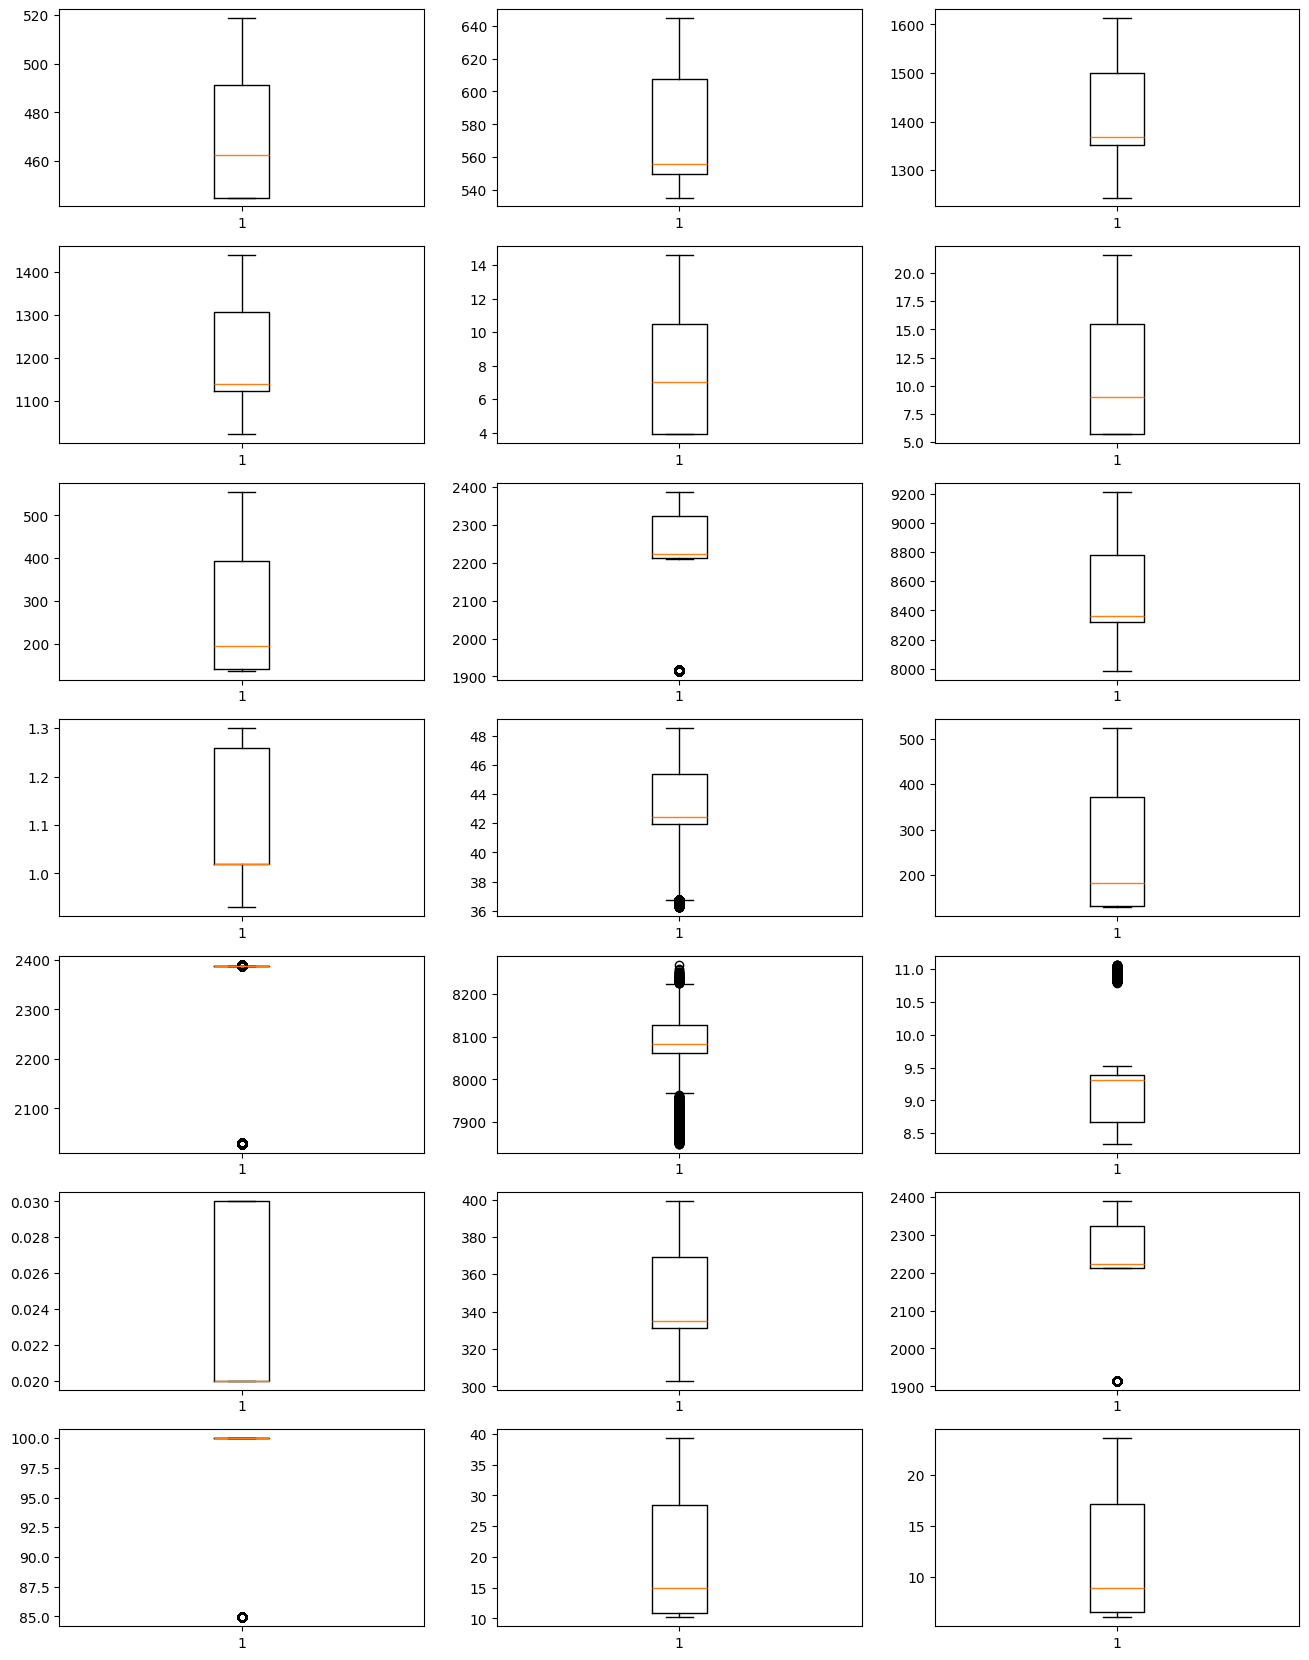

In [3]:
train_data = pd.read_csv("../../CMAPSS/train_FD002.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

In [4]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [5]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length, num_features)
    
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
        
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [6]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function returns last examples, number of last examples (a scaler), a mask, and test_decoder sequence as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    if len(test_data_for_an_engine) < window_length:
        mask_length = window_length - len(test_data_for_an_engine)
        batched_test_data_for_an_engine = np.concatenate((test_data_for_an_engine,
                                                          np.zeros((mask_length, test_data_for_an_engine.shape[1]))))
        mask = np.concatenate((np.repeat([True], len(test_data_for_an_engine)), np.repeat([False], mask_length)))
        num_test_windows = 1    # This has to be 1 as number of data points is less than window length
        return batched_test_data_for_an_engine[np.newaxis, :], num_test_windows, mask[np.newaxis, :]                                                
    
    else:
        max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
        
        if max_num_test_batches < num_test_windows:
            required_len = (max_num_test_batches -1)* shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, max_num_test_batches, mask
        
        else:
            required_len = (num_test_windows - 1) * shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, num_test_windows, mask

In [7]:
test_data = pd.read_csv("../../CMAPSS/test_FD002.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("../../CMAPSS/RUL_FD002.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 150         
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []
test_mask = []

columns_to_be_dropped = [0,1,2,3,4]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
# scaler = MinMaxScaler(feature_range = (-1, 1))
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values


    # Prepare test data
    test_data_for_an_engine, num_windows, test_mask_for_an_engine = process_test_data(temp_test_data,
                                                                                      window_length = window_length,
                                                                                      shift = shift,
                                                                                      num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
    test_mask.append(test_mask_for_an_engine)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
test_mask = np.concatenate(test_mask)

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("Test mask shape: ", test_mask.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (46219, 30, 21)
Processed training ruls shape:  (46219,)
Processed test data shape:  (1267, 30, 21)
Test mask shape:  (1267, 30)
True RUL shape:  (259,)


In [8]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

In [9]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 38)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (36975, 30, 21)
Processed validation data shape:  (9244, 30, 21)
Processed train targets shape:  (36975,)
Processed validation targets shape:  (9244,)


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((processed_val_data, processed_val_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data, test_mask)).batch(128).prefetch(tf.data.AUTOTUNE)

2024-01-12 11:13:22.196622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 11:13:22.203890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 11:13:22.203971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 11:13:22.207024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 11:13:22.207112: I tensorflow/compile

In [11]:
def custom_loss_large(alpha):
    def loss(y_true, y_pred):
        difference = y_pred - y_true
        squared_difference = tf.square(y_pred - y_true)
        loss_value = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
        return tf.reduce_mean(loss_value)
    
    return loss





In [12]:
from tensorflow.keras.layers import LSTM, Dropout, Flatten, Dense
from tensorflow.keras import Sequential, regularizers
import tensorflow as tf
import kerastuner as kt
from kerastuner.tuners import RandomSearch
class MyHyperModel(kt.HyperModel): 
    def build(self, hp):
        # Definisci gli iperparametri da ottimizzare
        l1Nodes = hp.Int('l1Nodes', min_value=32, max_value=512, step=32)
        l2Nodes = hp.Int('l2Nodes', min_value=32, max_value=256, step=32)
        l3Nodes = hp.Int('l3Nodes', min_value=32, max_value=128, step=32)
        l4Nodes = hp.Int('l4Nodes', min_value=32, max_value=64, step=32)
        d1dense = hp.Int('d1dense', min_value=16, max_value=64, step=32)
        d2dense = hp.Int('d2dense', min_value=16, max_value=64, step=32)
        alpha = hp.Float('alpha', min_value=0.1, max_value=0.9, step=0.1)

        lstm1 = LSTM(l1Nodes, input_shape=(30,21), return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
        d1 = Dropout(0.2)
        lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
        d2 = Dropout(0.2)
        lstm3 = LSTM(l3Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
        d3 = Dropout(0.2)
        lstm4 = LSTM(l4Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
        d4 = Dropout(0.2)

        flatten = Flatten()

        dense1 = Dense(d1dense, activation='relu', kernel_regularizer=regularizers.l2(0.1))
        dense2 = Dense(d2dense, activation='relu', kernel_regularizer=regularizers.l2(0.1))
        output_dense = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))

        layers = [lstm1, d1, lstm2, d2, lstm3, d3, lstm4, d4, flatten, dense1, dense2, output_dense]

        model = Sequential(layers)

        # Compila il modello utilizzando gli iperparametri ottimizzati, inclusi alpha
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [128, 256, 512]),
            **kwargs,
        )

# Funzione di loss con parametro alpha

# Configura il tuner
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=100,
    directory='my_tuning_dir',
    project_name='lstm_large_tuning')

# Esegui la ricerca dei migliori iperparametri



/tmp/ipykernel_5122/2434216070.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt
2024-01-12 11:13:24.684615: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [13]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [15]:
tuner.search(processed_train_data, processed_train_targets, epochs=20, validation_data=(processed_val_data, processed_val_targets), callbacks = [stop_early])

Trial 16 Complete [00h 01m 50s]
val_loss: 0.10715023428201675

Best val_loss So Far: 0.10713352262973785
Total elapsed time: 00h 24m 46s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
480               |64                |l1Nodes
192               |96                |l2Nodes
32                |32                |l3Nodes
32                |32                |l4Nodes
16                |16                |d1dense
16                |48                |d2dense
0.1               |0.4               |alpha
256               |512               |batch_size

Epoch 1/20
145/145 [==============================] - 17s 71ms/step - loss: 2.8064 - val_loss: 0.1156
Epoch 2/20
145/145 [==============================] - 9s 61ms/step - loss: 0.1082 - val_loss: 0.1073
Epoch 3/20
145/145 [==============================] - 9s 61ms/step - loss: 0.1060 - val_loss: 0.1077
Epoch 4/20
145/145 [==============================] - 9s 60ms/step - loss: 0.1058 - val_loss: 0.1076
Epoch 5

KeyboardInterrupt: 

In [ ]:
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print("Best Hyperparameters:")
print(best_hps)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
lstm_large = tuner.hypermodel.build(best_hps)


2024-01-04 01:55:25.053923: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [ ]:
input_shape = (window_length, processed_train_data.shape[2])

In [ ]:
def train_model(net, train_data_iter, validation_data_iter, lr, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    loss_object = tf.keras.losses.MeanSquaredError()

    train_metric = tf.keras.metrics.MeanSquaredError()
    val_metric = tf.keras.metrics.MeanSquaredError()

    for epoch in range(num_epochs):
        for X, Y in train_data_iter:
            with tf.GradientTape() as tape:
                output = net(X, mask = None)
                l = loss_object(Y, output)
            gradients = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
            # Update metric
            train_metric.update_state(Y, output)

        # Validation loop
        for val_X, val_Y in validation_data_iter:
            val_output = net(val_X, mask = None)
            # Update validation metric
            val_metric.update_state(val_Y, val_output)
        
        train_mse = train_metric.result()
        val_mse = val_metric.result()

        print(f'epoch: {epoch + 1}, Training loss: {train_mse}, Validation loss: {val_mse}')

        # Reset metric states
        train_metric.reset_states()
        val_metric.reset_states()

In [ ]:
train_model(net = lstm_large, train_data_iter = train_dataset, validation_data_iter= val_dataset, lr = 0.001, num_epochs = 20)

2024-01-04 01:55:26.233579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-04 01:55:26.998965: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xff373c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-04 01:55:26.998995: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-04 01:55:27.003214: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-04 01:55:27.086691: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epoch: 1, Training loss: 0.04534448683261871, Validation loss: 0.03019680455327034
epoch: 2, Training loss: 0.02964797243475914, Validation loss: 0.02550743892788887
epoch: 3, Training loss: 0.025532232597470284, Validation loss: 0.022286806255578995
epoch: 4, Training loss: 0.023783743381500244, Validation loss: 0.022017471492290497
epoch: 5, Training loss: 0.022602088749408722, Validation loss: 0.021724188700318336
epoch: 6, Training loss: 0.02127857506275177, Validation loss: 0.01980498805642128
epoch: 7, Training loss: 0.0198831744492054, Validation loss: 0.018618566915392876
epoch: 8, Training loss: 0.017074571922421455, Validation loss: 0.01571510173380375
epoch: 9, Training loss: 0.013647615909576416, Validation loss: 0.011110194027423859
epoch: 10, Training loss: 0.008732998743653297, Validation loss: 0.006885645445436239


In [ ]:
lstm_large.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 416)           728832    
                                                                 
 dropout (Dropout)           (None, 30, 416)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 192)           467712    
                                                                 
 dropout_1 (Dropout)         (None, 30, 192)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 320)           656640    
                                                                 
 dropout_2 (Dropout)         (None, 30, 320)           0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 32)            4

In [ ]:
rul_pred_scaled = []
for test_data, test_mask in test_dataset:
    batch_pred = lstm_large(test_data, mask = test_mask)
    rul_pred_scaled.extend(batch_pred.numpy().reshape(-1))

rul_pred_scaled = np.array(rul_pred_scaled) # initially rul_pred_scaled was just a list. So converted it to numpy array.
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

In [ ]:
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
MAE = mean_absolute_error(true_rul, mean_pred_for_each_engine)
print("RMSE: ", RMSE)
print("MAE: ", MAE)

RMSE:  30.89639035977511
MAE:  21.25333010208538


In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last examples): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

RMSE (Taking only last examples):  30.94453157577648
MAE (Taking only last example):  21.10723385511103


In [23]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [ ]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  59215.84530025635


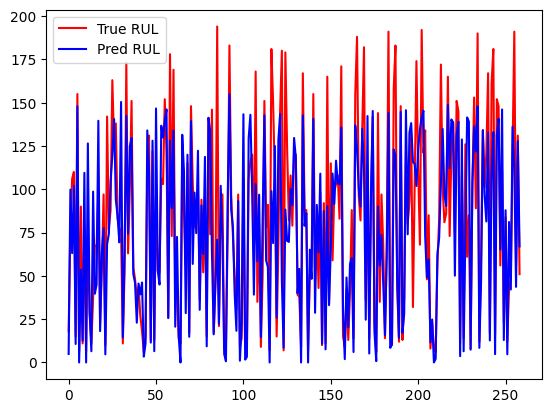

In [ ]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [14]:
def custom_loss(y_true, y_pred):
    alpha = 0.2
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

In [15]:
def asymmetric_loss(a, b):
    """
    Asymmetric Loss function.

    Parameters:
    - a: Weight for the negative part of the loss
    - b: Weight for the positive part of the loss

    Returns:
    - loss function
    """
    def loss(y_true, y_pred):
        d = y_pred - y_true
        loss_value = tf.where(d <= 0, -a * d, b * d)
        return tf.reduce_mean(loss_value)

    return loss

In [16]:

def createLSTMalternativeModel(l1Nodes, l2Nodes,l3Nodes, d1Nodes, d2Nodes, input_shape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=input_shape,activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    lstm2 = LSTM(l2Nodes, return_sequences = True, activation='tanh', kernel_regularizer = regularizers.l2(0.1))
    lstm3 = LSTM(l3Nodes, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(0.1))    
    flatten = Flatten()
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    #layers
    layers = [lstm1, lstm2,lstm3,flatten,  dense1, dense2, outL]
    model = Sequential(layers)
    #Abbiamo aggiunto le nostre funzioni di loss e accuracy definite precedentemente

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=asymmetric_loss(1.0, 2.0))
    return model


In [17]:

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch >= 10 and epoch < 20 :
        return 0.001
    elif epoch >= 20 and epoch < 30: 
        return 0.0001
    elif epoch >= 30: 
        return 0.00001
    else: 
        return 0.01; 

In [18]:
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)


EPOCHS = 50
BATCH_SIZE = 256 
lstm_alternative = createLSTMalternativeModel(128,64,32,64,96,(30,21))
callbacks = [stop_early, callback2]

history = lstm_alternative.fit(processed_train_data, processed_train_targets, epochs=EPOCHS, 
                               validation_data=(processed_val_data, processed_val_targets), 
                               callbacks=callbacks, 
                               batch_size=BATCH_SIZE)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50


2024-01-12 11:14:02.719049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-12 11:14:04.159317: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5a58135320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-12 11:14:04.159376: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2024-01-12 11:14:04.171434: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-12 11:14:04.318689: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/145 [==============================] - 15s 43ms/step - loss: 13.2314 - val_loss: 1.5136 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
145/145 [==============================] - 5s 36ms/step - loss: 0.6347 - val_loss: 0.3181 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
145/145 [==============================] - 5s 37ms/step - loss: 0.3003 - val_loss: 0.3148 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
145/145 [==============================] - 5s 34ms/step - loss: 0.2855 - val_loss: 0.2941 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/50
145/145 [==============================] - 5s 35ms/step - loss: 0.2824 - val_loss: 0.2857 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/50
145/145 [===================

In [19]:
rul_pred_scaled = []
for test_data, test_mask in test_dataset:
    batch_pred = lstm_alternative(test_data, mask = test_mask)
    rul_pred_scaled.extend(batch_pred.numpy().reshape(-1))

rul_pred_scaled = np.array(rul_pred_scaled) # initially rul_pred_scaled was just a list. So converted it to numpy array.
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

In [20]:
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
MAE = mean_absolute_error(true_rul, mean_pred_for_each_engine)
print("RMSE: ", RMSE)
print("MAE: ", MAE)

RMSE:  32.02283675357649
MAE:  22.369287413151568


In [21]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last examples): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

RMSE (Taking only last examples):  31.82302957273189
MAE (Taking only last example):  22.255109552250865


In [24]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  30862.86838018937


In [25]:
#del lstm_alternative

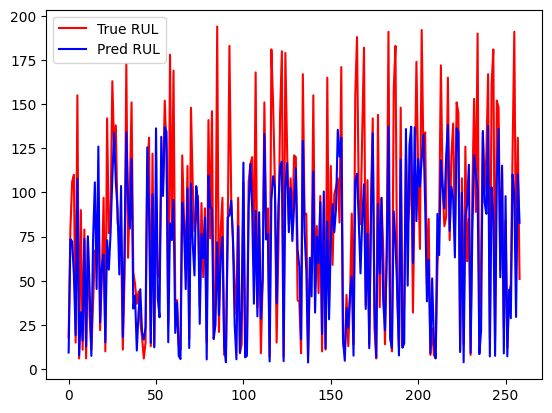

In [26]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [27]:
from tflite_converter import convert_to_tflite
MODEL_DIR = './models/FD002/LSTMAlternative'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 21
nome = "lstm_alternative"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, lstm_alternative, nome)

INFO:tensorflow:Assets written to: ./models/FD002/LSTMAlternative/assets


INFO:tensorflow:Assets written to: ./models/FD002/LSTMAlternative/assets
/home/aliquodfahriam/tinyML/Riproduzione/Experimental/tflite_converter.py:16: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(modello, nome_modello+".h5")
2024-01-12 11:19:24.022614: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-12 11:19:24.022686: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-12 11:19:24.028876: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ./models/FD002/LSTMAlternative
2024-01-12 11:19:24.054452: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-12 11:19:24.054508: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug